In Lab (1), we develop a simplified training pipeline. To obtain better training result, we will improve the
training pipeline by employing data augmentation, improving the model design, and tuning the hyperpa-
rameters.


# Lab 2 Part A

6 pts) Data augmentation techniques help combat overfitting. A typical strategy for CIFAR classifica-
tion is to combine 1) random cropping with a padding of 4 and 2) random flipping. Train a model with
such augmentation. How is the validation accuracy compared with the one without augmentation?
Note that in the following questions we all use augmentation. Also remember to reinitialize the
model whenever you start a new trainin

In [83]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [84]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


model = SimpleNN()

## Step 1: Set up preprocessing functions

In [85]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))]
)

transform_val = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
    ]
)

# Define data augmentation for training data
transform_train_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),       # Augmentation: random crop with padding
    transforms.RandomHorizontalFlip(),          # Augmentation: random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                         std=[0.2023, 0.1994, 0.2010])
])

# Define preprocessing for validation data (no augmentation)
transform_val_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])
#############################################

## Step 2: Set up dataset and dataloader

In [86]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train   # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val # your code
)
# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE ,  # your code
    shuffle= True,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data\cifar10_trainval_F22.zip
Extracting ./data\cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data\cifar10_trainval_F22.zip
Extracting ./data\cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


In [87]:
#AUGMENTED DATA
#############################################
# your code here
# construct dataset for data with augmentation 
train_set_aug = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train_aug   # your code
)
val_set_aug = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val_aug # your code
)
# construct dataloader
train_loader_aug = DataLoader(
    train_set_aug, 
    batch_size=TRAIN_BATCH_SIZE ,  # your code
    shuffle= True,     # your code
    num_workers=4
)
val_loader_aug = DataLoader(
    val_set_aug, 
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################


Using downloaded and verified file: ./data\cifar10_trainval_F22.zip
Extracting ./data\cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data\cifar10_trainval_F22.zip
Extracting ./data\cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.



In [88]:
# specify the device for computation
#############################################
# your code here
device = torch.device("cuda")

model.to(device)
print(device)
!nvidia-smi
#############################################

cuda
Thu Feb 20 01:59:35 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   36C    P8    26W / 320W |   4272MiB / 10240MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

In [89]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG) #Modified to L2 regularization



## Step 5: Start the training process.


Turned step 5 into a function so that i can just call it and change the variables such as the epoch, model, optimizer, data etc as necessary without making a mistake and leaving room for huma error

In [ ]:
def train_test_NN(train_loader, val_loader, model, epoch, lr, optimizer, criterion, device, checkpoint_folder):
    best_val_acc = 0
    current_learning_rate = INITIAL_LR

    print("==> Training starts!")
    print("="*50)

    l_train_acc = []
    l_train_loss = []
    l_val_acc = []
    l_val_loss = []

    for i in range(1, epoch+1):    
        #######################
        # your code here
        # switch to train mode
        model.train()
        
        #######################
    
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want
        
        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # zero the gradient
            optimizer.zero_grad()
            
            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)

            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            
            train_loss += loss.item()
            ####################################
                    
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        l_train_acc.append(avg_acc)
        l_train_loss.append(avg_loss)
        #Print per 10 epochs
        if i % 10 == 0 or i == 1:
            print(f"EPOCH: {i}, Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")
       
        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        
        model.eval()
        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs, targets = inputs.to(device), targets.to(device)
                
                # compute the output and loss
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # count the number of correctly predicted samples in the current batch
                _, predicted = outputs.max(1)
                total_examples += targets.size(0)
                correct_examples += predicted.eq(targets).sum().item()
                
                val_loss += loss.item() 
                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        l_val_loss.append(avg_loss)
        l_val_acc.append(avg_acc)
        #Print per 10 epochs
        if i % 10 == 0 or i == 1:
             print(f"EPOCH: {i}, Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")
        
        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            #print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))
            
        #print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    return l_train_acc, l_train_loss, l_val_acc, l_val_loss

## Model without augmentation

In [91]:

# initialize model with data augmentation
model_basic = SimpleNN().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(model_basic.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# some hyperparameters
# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model without data augmentation
l_train_acc_basic, _, l_val_acc_basic, _ = train_test_NN(
    train_loader, 
    val_loader, 
    model_basic, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.8757, Training accuracy: 0.3059
EPOCH: 1, Validation loss: 1.5620, Validation accuracy: 0.4364
EPOCH: 10, Training loss: 0.7684, Training accuracy: 0.7294
EPOCH: 10, Validation loss: 1.0541, Validation accuracy: 0.6396
EPOCH: 20, Training loss: 0.4411, Training accuracy: 0.8412
EPOCH: 20, Validation loss: 1.3667, Validation accuracy: 0.6342
EPOCH: 30, Training loss: 0.2936, Training accuracy: 0.8946
EPOCH: 30, Validation loss: 1.9676, Validation accuracy: 0.6074
==> Optimization finished! Best validation accuracy: 0.6414


## Model with Augmentation 

In [92]:
# initialize model with data augmentation
model_with_aug = SimpleNN().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(model_with_aug.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model with data augmentation
l_train_acc_aug, _, l_val_acc_aug, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_with_aug, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.9538, Training accuracy: 0.2749
EPOCH: 1, Validation loss: 1.6426, Validation accuracy: 0.3822
EPOCH: 10, Training loss: 1.1204, Training accuracy: 0.6028
EPOCH: 10, Validation loss: 1.0629, Validation accuracy: 0.6252
EPOCH: 20, Training loss: 0.9648, Training accuracy: 0.6603
EPOCH: 20, Validation loss: 0.9268, Validation accuracy: 0.6822
EPOCH: 30, Training loss: 0.8939, Training accuracy: 0.6854
EPOCH: 30, Validation loss: 0.8751, Validation accuracy: 0.6942
==> Optimization finished! Best validation accuracy: 0.7016


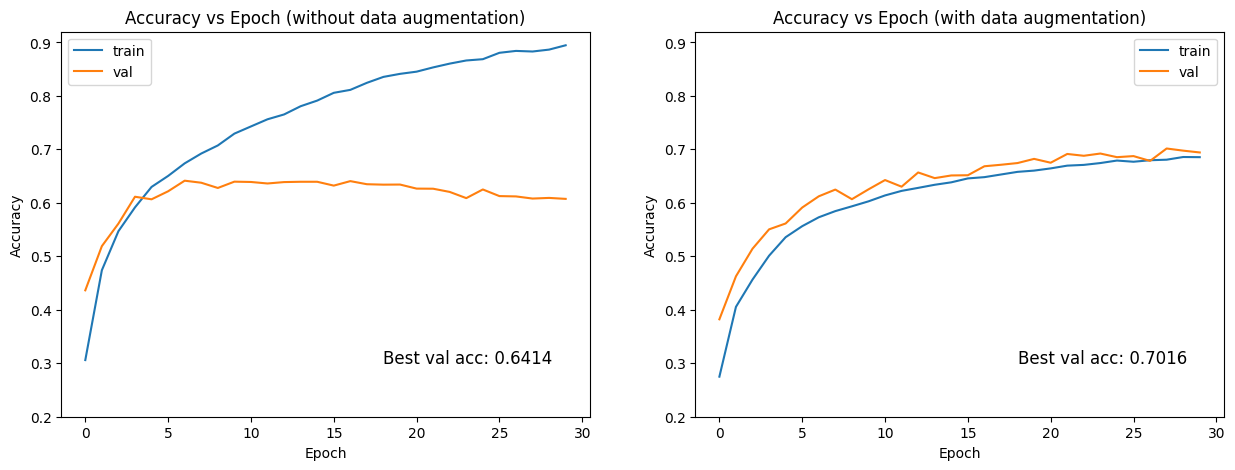

In [95]:
# visualize the training process
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(np.arange(EPOCHS), l_train_acc_basic, label='train')
ax1.plot(np.arange(EPOCHS), l_val_acc_basic, label='val')
ax1.set_ylim([0.2, 0.92])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Epoch (without data augmentation)')
ax1.text(s=f"Best val acc: {np.max(l_val_acc_basic):.4f}", x=18, y=0.3, fontsize=12)
ax1.legend()


ax2.plot(np.arange(EPOCHS), l_train_acc_aug, label='train')
ax2.plot(np.arange(EPOCHS), l_val_acc_aug, label='val')
ax2.set_ylim([0.2, 0.92])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch (with data augmentation)')
ax2.text(s=f"Best val acc: {np.max(l_val_acc_aug):.4f}", x=18, y=0.3, fontsize=12)
ax2.legend()
plt.show()

# Lab2 Part B

### Batch normalization Simple NN

In [96]:
class SimpleNN_BN(nn.Module):
    def __init__(self):
        super(SimpleNN_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [97]:
# initialize model with batch normalization
model_with_BN = SimpleNN_BN().to(device)

# hyperparameters
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model_with_BN.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

# start training model with batch normalization
l_train_acc_with_BN, _, l_val_acc_with_BN, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_with_BN, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.7493, Training accuracy: 0.3540
EPOCH: 1, Validation loss: 1.4627, Validation accuracy: 0.4700
EPOCH: 10, Training loss: 1.0246, Training accuracy: 0.6350
EPOCH: 10, Validation loss: 0.9722, Validation accuracy: 0.6566
EPOCH: 20, Training loss: 0.8996, Training accuracy: 0.6823
EPOCH: 20, Validation loss: 0.8461, Validation accuracy: 0.7086
EPOCH: 30, Training loss: 0.8277, Training accuracy: 0.7106
EPOCH: 30, Validation loss: 0.8210, Validation accuracy: 0.7150
==> Optimization finished! Best validation accuracy: 0.7214


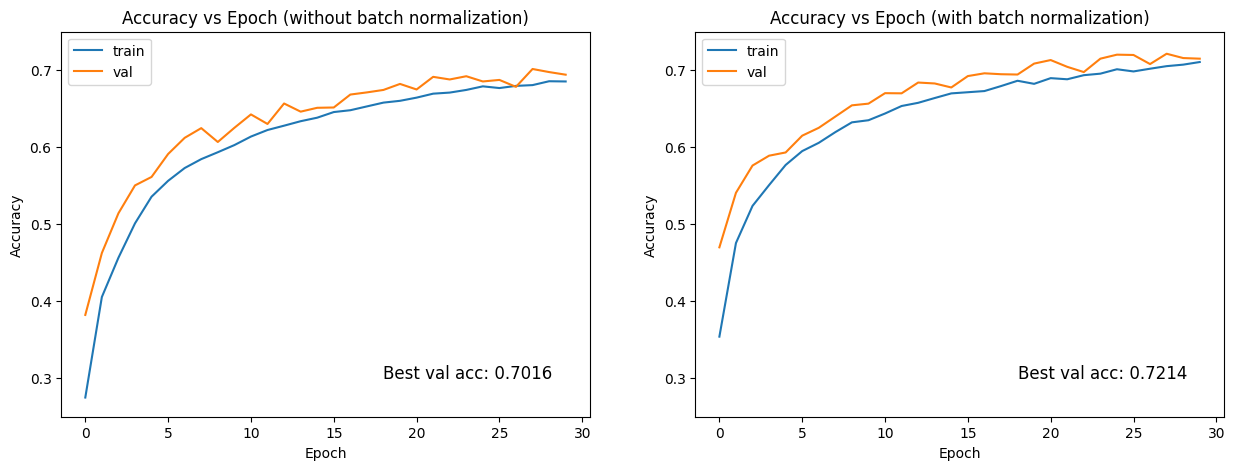

In [98]:
# plot the training curve of both models in two subplots with and without batch normalization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(np.arange(EPOCHS), l_train_acc_aug, label='train')
ax1.plot(np.arange(EPOCHS), l_val_acc_aug, label='val')
ax1.set_ylim([0.25, 0.75])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Epoch (without batch normalization)')
ax1.text(s=f"Best val acc: {np.max(l_val_acc_aug):.4f}", x=18, y=0.3, fontsize=12)
ax1.legend()

ax2.plot(np.arange(EPOCHS), l_train_acc_with_BN, label='train')
ax2.plot(np.arange(EPOCHS), l_val_acc_with_BN, label='val')
ax2.set_ylim([0.25, 0.75])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch (with batch normalization)')
ax2.text(s=f"Best val acc: {np.max(l_val_acc_with_BN):.4f}", x=18, y=0.3, fontsize=12)
ax2.legend()
plt.show()

In [102]:
# reset model weights  function is used to reinitialize the weights of the neural network layers. 
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()

In [103]:
# reset the model weights
model_with_BN.apply(weight_reset)

# increase learning rate from 0.01 to 0.1
Lr_2 = 0.1

l_train_acc_with_BN, _, l_val_acc_with_BN, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_with_BN, 
    EPOCHS, 
    Lr_2, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.7589, Training accuracy: 0.3474
EPOCH: 1, Validation loss: 1.4451, Validation accuracy: 0.4744
EPOCH: 10, Training loss: 1.0303, Training accuracy: 0.6360
EPOCH: 10, Validation loss: 1.0075, Validation accuracy: 0.6434
EPOCH: 20, Training loss: 0.8990, Training accuracy: 0.6822
EPOCH: 20, Validation loss: 0.8518, Validation accuracy: 0.6998
EPOCH: 30, Training loss: 0.8365, Training accuracy: 0.7061
EPOCH: 30, Validation loss: 0.8200, Validation accuracy: 0.7180
==> Optimization finished! Best validation accuracy: 0.7230


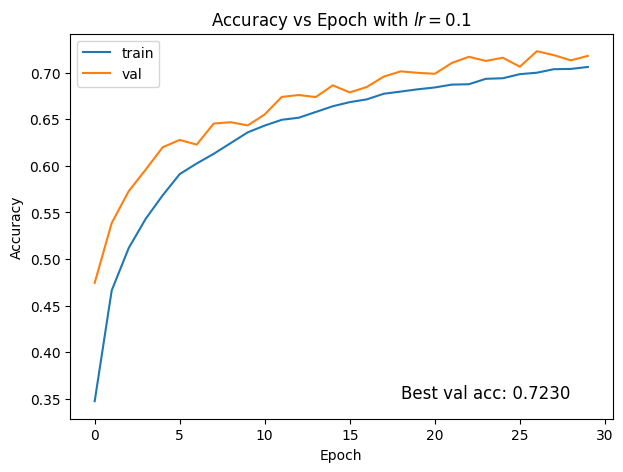

In [104]:
# plot the training curve 
plt.figure(figsize=(7, 5))
plt.plot(np.arange(EPOCHS), l_train_acc_with_BN, label='train')
plt.plot(np.arange(EPOCHS), l_val_acc_with_BN, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with $lr=0.1$')
plt.text(s=f"Best val acc: {np.max(l_val_acc_with_BN):.4f}", x=18, y=0.35, fontsize=12)
plt.legend()
plt.show()

#### Switch ReLU to Swish

In [111]:
# define the SimpleNN Swish mode;

def swish(x):
    return x * torch.sigmoid(x)

class SwishNN(nn.Module):
    def __init__(self):
        super(SwishNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = swish(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = swish(self.fc1(out))
        out = swish(self.fc2(out))
        out = self.fc3(out)
        return out

In [112]:
# initialize model with swish activation function
model_swish = SwishNN().to(device)

# hyperparameters
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model_swish.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

l_train_acc_swish, _, l_val_acc_swish, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_swish, 
    EPOCHS, 
    Lr_2, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.7975, Training accuracy: 0.3379
EPOCH: 1, Validation loss: 1.4464, Validation accuracy: 0.4734
EPOCH: 10, Training loss: 0.9880, Training accuracy: 0.6505
EPOCH: 10, Validation loss: 0.9626, Validation accuracy: 0.6646
EPOCH: 20, Training loss: 0.8461, Training accuracy: 0.7021
EPOCH: 20, Validation loss: 0.7854, Validation accuracy: 0.7270
EPOCH: 30, Training loss: 0.7788, Training accuracy: 0.7248
EPOCH: 30, Validation loss: 0.7858, Validation accuracy: 0.7240
==> Optimization finished! Best validation accuracy: 0.7384


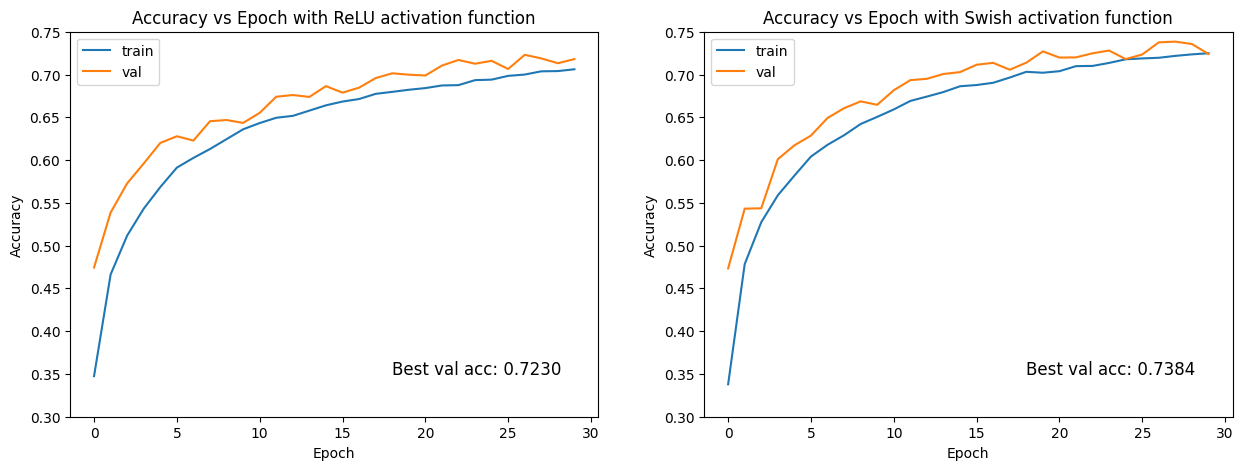

In [113]:
# plot the training curve of both models in two subplots with ReLU and Swish activation functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(np.arange(EPOCHS), l_train_acc_with_BN, label='train')
ax1.plot(np.arange(EPOCHS), l_val_acc_with_BN, label='val')
ax1.set_ylim([0.3, 0.75])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Epoch with ReLU activation function')
ax1.text(s=f"Best val acc: {np.max(l_val_acc_with_BN):.4f}", x=18, y=0.35, fontsize=12)
ax1.legend()

ax2.plot(np.arange(EPOCHS), l_train_acc_swish, label='train')
ax2.plot(np.arange(EPOCHS), l_val_acc_swish, label='val')
ax2.set_ylim([0.3, 0.75])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch with Swish activation function')
ax2.text(s=f"Best val acc: {np.max(l_val_acc_swish):.4f}", x=18, y=0.35, fontsize=12)
ax2.legend()
plt.show()

## Lab 2 Part C

#### Learning rate tuning 

In [114]:
l_Lr = [1, 0.1, 0.05, 0.01, 0.005, 0.001]
lr_val_acc = []

# hyperparameters
MOMENTUM = 0.9
REG = 1e-4
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

for lr in l_Lr:
    print(f"==> Current learning rate is: {lr}")

    # initialize model with swish activation function
    model = SwishNN().to(device)
    model.apply(weight_reset)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=REG)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_NN( 
        train_loader_aug, 
        val_loader_aug, 
        model, 
        EPOCHS, 
        lr, 
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER
    )

    # save the validation accuracy list
    lr_val_acc.append(l_val_acc)

==> Current learning rate is: 1
==> Training starts!
EPOCH: 1, Training loss: nan, Training accuracy: 0.1044
EPOCH: 1, Validation loss: nan, Validation accuracy: 0.1028
EPOCH: 10, Training loss: nan, Training accuracy: 0.0999
EPOCH: 10, Validation loss: nan, Validation accuracy: 0.1028
EPOCH: 20, Training loss: nan, Training accuracy: 0.0999
EPOCH: 20, Validation loss: nan, Validation accuracy: 0.1028
EPOCH: 30, Training loss: nan, Training accuracy: 0.0999
EPOCH: 30, Validation loss: nan, Validation accuracy: 0.1028
==> Optimization finished! Best validation accuracy: 0.1028
==> Current learning rate is: 0.1
==> Training starts!
EPOCH: 1, Training loss: 1.6380, Training accuracy: 0.3960
EPOCH: 1, Validation loss: 1.4247, Validation accuracy: 0.4750
EPOCH: 10, Training loss: 0.9806, Training accuracy: 0.6520
EPOCH: 10, Validation loss: 0.9206, Validation accuracy: 0.6770
EPOCH: 20, Training loss: 0.8923, Training accuracy: 0.6858
EPOCH: 20, Validation loss: 0.8180, Validation accuracy:

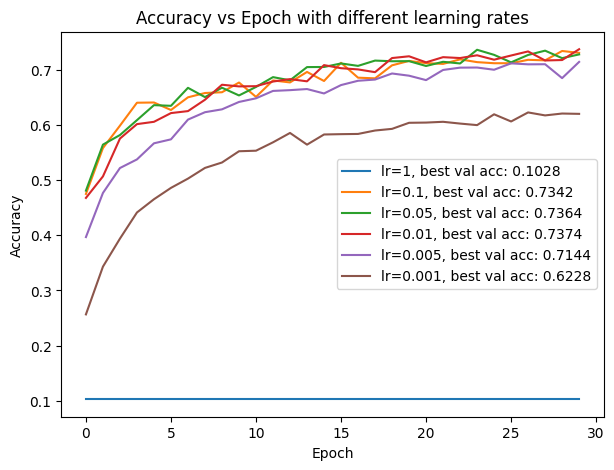

In [115]:
# plot the six learning curves in one figure
plt.figure(figsize=(7, 5))
for i, lr in enumerate(l_Lr):
    plt.plot(np.arange(EPOCHS), lr_val_acc[i], label=f'lr={lr}, best val acc: {np.max(lr_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different learning rates')
plt.legend()
plt.show()

#### Tuning L2 Regularization strength

In [116]:
l_REG = [1e-2, 1e-3, 1e-4, 1e-5, 0]
l2_reg_val_acc = []

# hyperparameters
MOMENTUM = 0.9
INITIAL_LR = 0.01
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

for reg in l_REG:
    print(f"==> Current L2 regularization strength is: {reg}")
    # initialize model with swish activation function
    model = SwishNN().to(device)
    model.apply(weight_reset)
    optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=reg)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_NN(
        train_loader_aug, 
        val_loader_aug, 
        model, 
        EPOCHS, 
        INITIAL_LR, 
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER
    )

    # save the best validation accuracy
    l2_reg_val_acc.append(l_val_acc)

==> Current L2 regularization strength is: 0.01
==> Training starts!
EPOCH: 1, Training loss: 1.8552, Training accuracy: 0.3018
EPOCH: 1, Validation loss: 1.5615, Validation accuracy: 0.4268
EPOCH: 10, Training loss: 1.2923, Training accuracy: 0.5390
EPOCH: 10, Validation loss: 1.1815, Validation accuracy: 0.5828
EPOCH: 20, Training loss: 1.2112, Training accuracy: 0.5722
EPOCH: 20, Validation loss: 1.1529, Validation accuracy: 0.5812
EPOCH: 30, Training loss: 1.1761, Training accuracy: 0.5872
EPOCH: 30, Validation loss: 1.1621, Validation accuracy: 0.5826
==> Optimization finished! Best validation accuracy: 0.6096
==> Current L2 regularization strength is: 0.001
==> Training starts!
EPOCH: 1, Training loss: 1.8189, Training accuracy: 0.3270
EPOCH: 1, Validation loss: 1.4886, Validation accuracy: 0.4464
EPOCH: 10, Training loss: 1.0213, Training accuracy: 0.6387
EPOCH: 10, Validation loss: 0.9675, Validation accuracy: 0.6602
EPOCH: 20, Training loss: 0.8931, Training accuracy: 0.6831
E

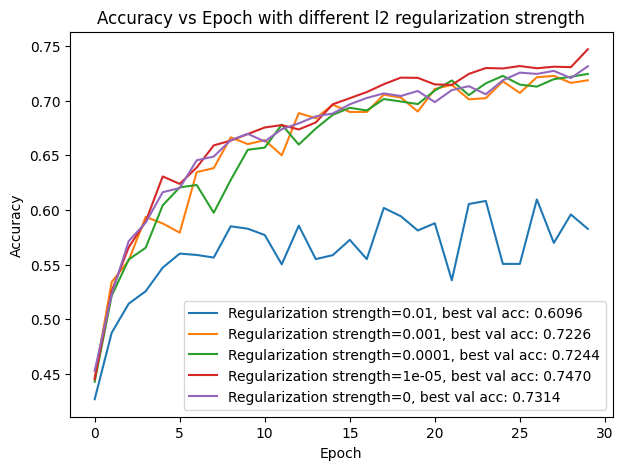

In [117]:
# plot the six learning curves
plt.figure(figsize=(7, 5))
for i, reg in enumerate(l_REG):
    plt.plot(np.arange(EPOCHS), l2_reg_val_acc[i], label=f'Regularization strength={reg}, best val acc: {np.max(l2_reg_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different l2 regularization strength')
plt.legend()
plt.show()

# Bonus: Switch penalty from L2 to L1 

In [121]:
def train_test_L1(train_loader, val_loader, model, epoch, lr, l1_lamda, optimizer, criterion, device, checkpoint_folder):
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    current_learning_rate = lr

    print("==> Training starts!")
    print("="*50)

    l_train_acc = []
    l_train_loss = []
    l_val_acc = []
    l_val_loss = []

    for i in range(0, epoch):
        
        #######################
        # your code here
        # switch to train mode
        model.train()

        #######################
        
        print("Epoch %d:" %i)
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want

        
        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # zero the gradient
            optimizer.zero_grad()
            
            # compute L1 regularization loss
            l1_reg = torch.tensor(0.).to(device)
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    l1_reg += torch.norm(param, 1)
            loss += l1_lamda * l1_reg

            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            
            # add to totals
            train_loss += loss.item()
            total_examples += targets.size(0)
            correct_examples += correct.item()
            ####################################
                    
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        l_train_acc.append(avg_acc)
        l_train_loss.append(avg_loss)
        print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        model.eval()
        
        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # compute the output and loss
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # count the number of correctly predicted samples in the current batch
                _, predicted = torch.max(outputs, 1)
                correct = predicted.eq(targets).sum()
                
                # add to totals
                val_loss += loss.item()
                total_examples += targets.size(0)
                correct_examples += correct.item()
                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        l_val_loss.append(avg_loss)
        l_val_acc.append(avg_acc)
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        
        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(checkpoint_folder):
                os.makedirs(checkpoint_folder)
            print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(checkpoint_folder, 'simplenn.pth'))
            
        print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    return l_train_acc, l_train_loss, l_val_acc, l_val_loss

In [122]:
# initialize model with L1 regularization
model_L1 = SwishNN().to(device)

# hyperparameters
INITIAL_LR = 0.01
MOMENTUM = 0.9
L1_lAMBDA = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model_L1.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=0)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

l_train_acc_L1, _, l_val_acc_L1, _ = train_test_L1(
    train_loader_aug, 
    val_loader_aug, 
    model_L1, 
    EPOCHS, 
    INITIAL_LR, 
    L1_lAMBDA, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
Epoch 0:
Training loss: 2.0095, Training accuracy: 0.3302
Validation loss: 1.4966, Validation accuracy: 0.4440
Saving ...

Epoch 1:
Training loss: 1.6588, Training accuracy: 0.4646
Validation loss: 1.2904, Validation accuracy: 0.5336
Saving ...

Epoch 2:
Training loss: 1.5281, Training accuracy: 0.5129
Validation loss: 1.2262, Validation accuracy: 0.5578
Saving ...

Epoch 3:
Training loss: 1.4545, Training accuracy: 0.5402
Validation loss: 1.1539, Validation accuracy: 0.5902
Saving ...

Epoch 4:
Training loss: 1.4037, Training accuracy: 0.5565
Validation loss: 1.1707, Validation accuracy: 0.5800

Epoch 5:
Training loss: 1.3555, Training accuracy: 0.5738
Validation loss: 1.0924, Validation accuracy: 0.6142
Saving ...

Epoch 6:
Training loss: 1.3129, Training accuracy: 0.5881
Validation loss: 1.0889, Validation accuracy: 0.6052

Epoch 7:
Training loss: 1.2906, Training accuracy: 0.5987
Validation loss: 1.0545, Validation accuracy: 0.6248
Saving ...

Epoch 8:
Training

In [123]:
# intialize model with L2 regularization
model_L2 = SwishNN().to(device)

# hyperparameters
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model_L2.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

l_train_acc_L2, _, l_val_acc_L2, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_L2, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.8486, Training accuracy: 0.3196
EPOCH: 1, Validation loss: 1.4742, Validation accuracy: 0.4506
EPOCH: 10, Training loss: 1.0046, Training accuracy: 0.6429
EPOCH: 10, Validation loss: 0.9675, Validation accuracy: 0.6656
EPOCH: 20, Training loss: 0.8595, Training accuracy: 0.6962
EPOCH: 20, Validation loss: 0.8333, Validation accuracy: 0.7028
EPOCH: 30, Training loss: 0.7868, Training accuracy: 0.7218
EPOCH: 30, Validation loss: 0.8013, Validation accuracy: 0.7178
==> Optimization finished! Best validation accuracy: 0.7278


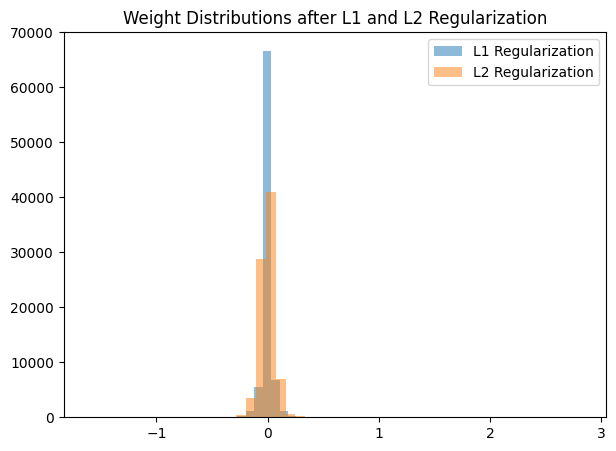

In [124]:
def plot_weight_histogram(model, title):
    all_weights = []
    for param in model.parameters():
        all_weights += list(param.cpu().detach().numpy().flatten())
    plt.hist(all_weights, bins=50, alpha=0.5, label=title)

plt.figure(figsize=(7, 5))
plot_weight_histogram(model_L1, 'L1 Regularization')  # Assuming 'model_swish' is trained with L1
plot_weight_histogram(model_L2, 'L2 Regularization')  # 'model_l2' is a placeholder, replace with your L2-trained model.
plt.title('Weight Distributions after L1 and L2 Regularization')
plt.legend()
plt.show()